In [6]:
import sys, os
import warnings
import h5py
import numpy as np
from joblib import delayed, Parallel
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn.metrics import pairwise_distances

from scipy.stats._stats import _center_distance_matrix

sys.path.append(os.path.realpath('..'))

In [7]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import pairwise_distances

from scipy.stats.distributions import chi2
from hyppo.independence.base import IndependenceTest
from hyppo.independence.dcorr import _dcorr
from hyppo.independence._utils import sim_matrix


FOREST_TYPES = {
    "classifier" : RandomForestClassifier,
    "regressor" : RandomForestRegressor
}


class KMERF(IndependenceTest):
    r"""
    Class for calculating the random forest based Dcorr test statistic and p-value.
    """

    def __init__(self, forest="regressor", ntrees=500, **kwargs):
        if forest in FOREST_TYPES.keys():
            self.clf = FOREST_TYPES[forest](n_estimators=ntrees, **kwargs)
        else:
            raise ValueError("forest must be one of the following ")
        IndependenceTest.__init__(self)

    def statistic(self, x, y):
        r"""
        Helper function that calculates the random forest based Dcorr test statistic.
        """
        rf_y = y.ravel()
        if y.shape[1] == 1:
            rf_y = y.ravel()
        self.clf.fit(x, rf_y)
        distx = np.sqrt(1 - sim_matrix(self.clf, x))
        if x.shape[1] == y.shape[1]:
            disty = np.sqrt(1 - sim_matrix(self.clf, y))
        else:
            disty = pairwise_distances(
                y, metric="euclidean"
            )
        stat = _dcorr(distx, disty, bias=False, is_fast=False)

        return stat

    def test(self, x, y):
        n = x.shape[0]
        stat = self.statistic(x, y)
        statx = self.statistic(x, x)
        staty = self.statistic(y, y)
        pvalue = chi2.sf(stat / np.sqrt(statx * staty) * n + 1, 1)
        return stat, pvalue

In [8]:
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE)

In [9]:
# import mat file
arrays = {}
f = h5py.File("../kmerf/real_data/proteomics.mat")
for k, v in f.items():
    arrays[k] = np.array(v)

In [10]:
def compute_pvalue(D, A, per, i):
    C = A[per.ravel(), i]
    return KMERF().test(C.reshape(-1, 1), D.reshape(-1, 1))[1]


def generate_perd(labelindall, vs_type):
    if vs_type == "pancvsnormal":
        per = np.logical_or(labelindall == 1, labelindall == 2)
    elif vs_type == "pancvsall":
        per = np.logical_and(labelindall != 2, labelindall < 5)
        labelindall[per] = 1
        per = labelindall < 5
    else:
        raise ValueError("vs_type must be pancvsnormal or pancvsall")

    D = labelindall[per]

    return per, D


def generate_pvalues(arrays, vs_type="pancvsnormal"):
    labelindall = arrays['LabelIndAll']
    A = arrays['A']

    per, D = generate_perd(labelindall, vs_type)

    pvalues = Parallel(n_jobs=-1, verbose=100)(
        [delayed(compute_pvalue)(D, A, per, i) for i in range(A.shape[1])]
    )
    return pvalues

In [11]:
panc_vs_normal = generate_pvalues(arrays, vs_type="pancvsnormal")
np.savetxt('../kmerf/real_data/panc_vs_normal.csv', panc_vs_normal, delimiter=',')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 318 | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done   2 out of 318 | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   3 out of 318 | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   4 out of 318 | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   5 out of 318 | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done   6 out of 318 | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done   7 out of 318 | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   8 out of 318 | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done   9 out of 318 | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  10 out of 318 | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  11 out of 318 | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  12 out of 318 | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  13 out of 318 | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  14 out of 318 | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  15 out of 318 | elapsed:   

In [12]:
panc_vs_all = generate_pvalues(arrays, vs_type="pancvsall")
np.savetxt('../kmerf/real_data/panc_vs_all.csv', panc_vs_all, delimiter=',')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 318 | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   2 out of 318 | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of 318 | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of 318 | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of 318 | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   6 out of 318 | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   7 out of 318 | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   8 out of 318 | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 out of 318 | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of 318 | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  11 out of 318 | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  12 out of 318 | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  13 out of 318 | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  14 out of 318 | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  15 out of 318 | elapsed:   

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

# Load the data
X = arrays['A']
labelind = arrays['LabelInd'].ravel()
y = np.array([1 if label == 2 else 0 for label in labelind])

# Create the cross validator
cv = LeaveOneOut()

# Create the classifier
clf = KNeighborsClassifier(n_neighbors=10)

# Fit the classifier
for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)

# Evaluate the classifier
scores = []
for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scores.append(clf.predict(X_test))

scores = np.array(scores).ravel()
panc_ind = np.where(y == 1)[0]
print('Score:', scores[panc_ind] == y[panc_ind])

Score: [False False False False False False False False False]


In [14]:
def plot_real_data():
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    panc_vs_normal = np.genfromtxt('../kmerf/real_data/panc_vs_normal.csv', delimiter=',')
    panc_vs_all = np.genfromtxt('../kmerf/real_data/panc_vs_all.csv', delimiter=',')

    ax1.scatter(panc_vs_normal, panc_vs_all, c="#4daf4a", s=75)
    ax1.scatter(panc_vs_normal[180], panc_vs_all[180], c="#e41a1c", s=100)
    ax1.text(panc_vs_normal[180]+1e-6, panc_vs_all[180]+1e-6, c="#e41a1c", s="neurogranin")
#     ax1.axhline(y=1e-3, linestyle='--')
#     ax1.axvline(x=1e-5, linestyle='--')
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_xlabel("p-values for Panc vs Norm")
    ax1.set_ylabel("p-values for Panc vs All")
#     ax1.set_xticks([1e-2, 1e-1, 1e0])
#     ax1.set_yticks([1e-2, 1e-1, 1e0])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_title('Cancer Biomarker Discovery', pad=20)

    # See https://elifesciences.org/articles/41690#fig4
    # Same peptide identified, so identical tp/fp
    labels = ["False Positives", "True Positives"]
    data = {
        'KMERF': ([2, 5], "#e41a1c"),
        'Hsic': ([4, 5], "#4daf4a"),
        'HHG' : ([2, 1], "#984ea3"),
        'Other' : ([9, 0], "#ff7f00"),
    }
    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0

    for test, positives in data.items():
        offset = width * multiplier
        rects = ax2.bar(x + offset, positives[0], width, color=positives[1], label=test)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax2.set_ylabel("# True / False Positives")
    ax2.set_ylim([0, 10])
    ax2.set_xticks(x + width + width/2)
    ax2.set_xticklabels(labels)
    plt.legend()
    ax2.set_title('Biomarker kNN Classification', pad=20)
    leg = plt.legend(bbox_to_anchor=(0.8, 0.9), bbox_transform=plt.gcf().transFigure,
                     ncol=1, loc='upper center', labelspacing=.1)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    plt.subplots_adjust(wspace=0.3)
    plt.savefig('../kmerf/figs/real_data.pdf', transparent=True, bbox_inches='tight')

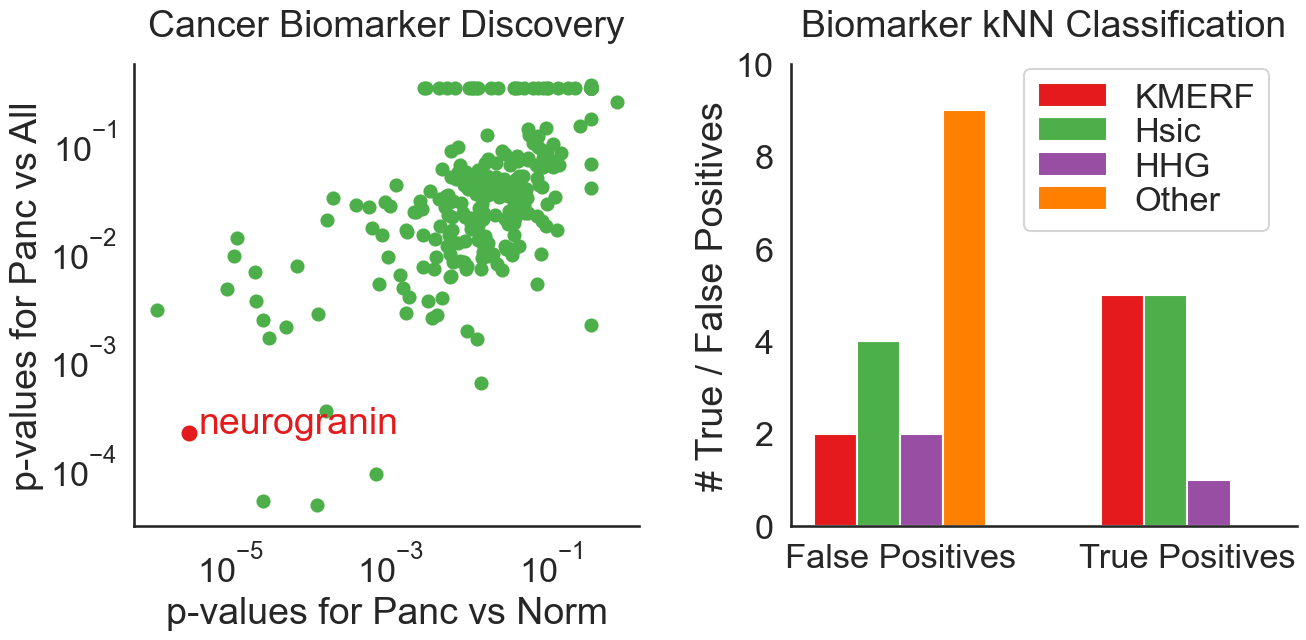

In [15]:
plot_real_data()